In [766]:
import torch 
import torch_geometric as pyg
import pandas as pd
import numpy as np
import omnipath as op 
from matplotlib import pyplot as plt 
import torch_geometric as pyg 
import copy 
import umap
from sklearn.decomposition import PCA
import seaborn as sbn

from gsnn.reinforce.Actor import Actor
from gsnn.reinforce.Environment import Environment
from gsnn.models.GSNN import GSNN
from gsnn.data.LincsDataset import LincsDataset
from gsnn.models import utils 
from gsnn.proc.utils import get_x_drug_conc             # required to unpickle data 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [767]:
result_dict = torch.load('../../output/rl_results_dict.pt')
NS = result_dict['actor']
NS.load_state_dict(result_dict['state_dict'])
data = torch.load('../../data/all/data.pt')

row,col = data.edge_index_dict['function','to','function']
N = len(data.node_names_dict['function'])
iD = pyg.utils.degree(row, num_nodes=N).detach().cpu().numpy()
oD = pyg.utils.degree(col, num_nodes=N).detach().cpu().numpy()
D = iD + oD

uni2sym = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')

res = pd.DataFrame({'node_name':data.node_names_dict['function'], 'prob':result_dict['node_prob'].ravel(), 'degree':D, 'in_degree':iD, 'out_degree':oD})
res = res.assign(From=lambda x: [xx.split('__')[1] for xx in x.node_name])
res = res.merge(uni2sym, on='From', how='left')

#_ = [print(x) for x in res.sort_values('prob', ascending=False).dropna().head(50).To.tolist()]

res.sort_values('prob', ascending=False).head(15)

,node_name,prob,degree,in_degree,out_degree,From,To
6123,RNA__O15392,1.0,36.0,1.0,35.0,O15392,BIRC5
7940,RNA__Q04759,1.0,3.0,1.0,2.0,Q04759,PRKCQ
7482,RNA__P46527,1.0,39.0,1.0,38.0,P46527,CDKN1B
9248,RNA__Q9NW15,1.0,4.0,0.0,4.0,Q9NW15,ANO10
6760,RNA__P10415,1.0,178.0,1.0,177.0,P10415,BCL2
7389,RNA__P38936,1.0,106.0,1.0,105.0,P38936,CDKN1A
6176,RNA__O43524,1.0,36.0,1.0,35.0,O43524,FOXO3
8204,RNA__Q14164,1.0,3.0,1.0,2.0,Q14164,IKBKE
7519,RNA__P49137,1.0,2.0,1.0,1.0,P49137,MAPKAPK2
8016,RNA__Q09472,1.0,10.0,1.0,9.0,Q09472,EP300


In [768]:
res.sort_values('prob', ascending=False).tail(10)

,node_name,prob,degree,in_degree,out_degree,From,To
6593,RNA__P05412,9.650042e-11,26.0,1.0,25.0,P05412,JUN
6454,RNA__P01111,1.934504e-11,12.0,1.0,11.0,P01111,NRAS
8410,RNA__Q16778,4.750546e-12,3.0,0.0,3.0,Q16778,H2BC21
569,PROTEIN__O43741,2.713323e-12,7.0,1.0,6.0,O43741,PRKAB2
6282,RNA__O75385,2.658525e-12,19.0,1.0,18.0,O75385,ULK1
6503,RNA__P02452,4.362119e-14,20.0,1.0,19.0,P02452,COL1A1
7851,RNA__P98170,1.108112e-14,30.0,1.0,29.0,P98170,XIAP
6295,RNA__O75530,4.549463e-18,2.0,1.0,1.0,O75530,EED
8284,RNA__Q15022,3.660130e-26,9.0,1.0,8.0,Q15022,SUZ12
8366,RNA__Q15910,8.265867e-27,31.0,1.0,30.0,Q15910,EZH2


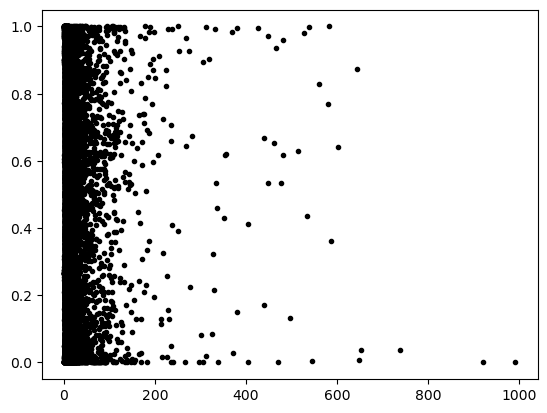

In [769]:
plt.figure()
plt.plot(res.degree, res.prob, 'k.')
plt.show()

In [770]:
row,col = data.edge_index_dict['input', 'to', 'function']
drug_idxs = torch.tensor([i for i,name in enumerate(data.node_names_dict['input']) if 'DRUG__' in name], dtype=torch.long)
dti_idxs = torch.isin(row, drug_idxs).nonzero(as_tuple=True)[0]
targ_idxs = col[dti_idxs]
targs = np.array(data.node_names_dict['function'])[targ_idxs]
print('# targets:', len(targs))
#res[lambda x: x.node_name.isin(targs)].sort_values('prob', ascending=False).head(30) 

# get all output RNAs 
row,col = data.edge_index_dict['function', 'to', 'output']
output_nodes = np.array(data.node_names_dict['function'])[row]
print('# output nodes', len(output_nodes))

# targets: 2687
# output nodes 585


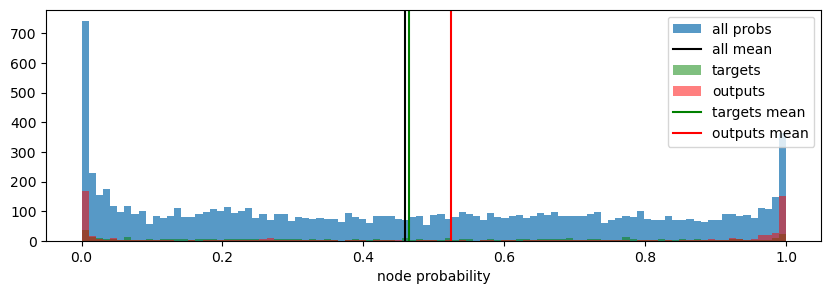

In [771]:
bins = np.linspace(0,1,100)
dens = False

plt.figure(figsize=(10,3))
plt.hist(res.prob, bins=bins, alpha=0.75, density=dens, label='all probs')
#for targ in targs: 
#    plt.axvline(res[lambda x: x.node_name == targ].prob.item(), c='g')
#plt.axvline(res[lambda x: x.node_name.isin(targs)].prob.mean().item(), c='y')
plt.axvline(res.prob.mean(), c='k', label='all mean')
plt.hist(res[lambda x: x.node_name.isin(targs)].prob, color='g', bins=bins, alpha=0.5, density=dens, label='targets')
plt.hist(res[lambda x: x.node_name.isin(output_nodes)].prob, color='r', bins=bins, alpha=0.5, density=dens, label='outputs')
##plt.axvline(res[lambda x: x.node_name == 'RNA__P04637'].prob.item(), c='r', label='RNA__TP53')

plt.axvline(res[lambda x: x.node_name.isin(targs)].prob.mean(), c='g', label='targets mean')
plt.axvline(res[lambda x: x.node_name.isin(output_nodes)].prob.mean(), c='r', label='outputs mean')
plt.xlabel('node probability')
plt.legend()
#plt.yscale('log')
plt.show()

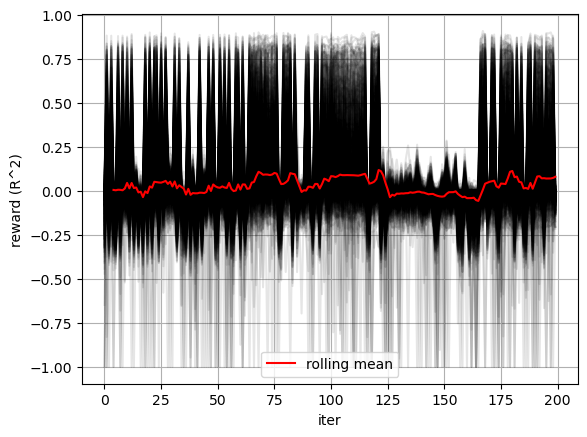

In [772]:
window=5
tmp = pd.DataFrame({'reward':np.stack(result_dict['ppo'].rewards, axis=0).mean(axis=1)})
tmp = tmp.assign(rm = tmp.rolling(window=window).mean(), 
                 rs = tmp.rolling(window=window).std(),
                 q05 = tmp.rolling(window=window).quantile(q=0.05),
                 q25 = tmp.rolling(window=window).quantile(q=0.25), 
                 q75 = tmp.rolling(window=window).quantile(q=0.75), 
                 q95 = tmp.rolling(window=window).quantile(q=0.95), 
                 )

plt.figure()
for i in range(len(result_dict['ppo'].rewards[0])): 
    plt.plot([r[i] for r in result_dict['ppo'].rewards], 'k-', alpha=0.1)

    #tmp2 = pd.DataFrame({'reward':[r[i] for r in result_dict['ppo'].rewards]})
    #tmp2 = tmp2.assign(rm = tmp2.rolling(window=window).mean())
    #plt.plot(tmp2.rm, 'r--')

plt.plot(tmp.rm, 'r-', label='rolling mean')

#plt.fill_between(range(len(tmp.rm)), tmp.q95, tmp.q05, color='b', alpha=0.1, label='rolling 90% CI')
#plt.fill_between(range(len(tmp.rm)), tmp.q75, tmp.q25, color='b', alpha=0.2, label='rolling 50% CI')
#plt.axvline(result_dict['args'].warmup - 1, c='k', label='warmup', alpha=0.5)
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel('reward (R^2)')
plt.show()

In [2]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')

p = np.array(result_dict['node_prob'])
env = result_dict['env']

result_dict.keys()

dict_keys(['state_dict', 'node_prob', 'reward_scaler', 'args', 'x', 'actor', 'data', 'model_kwargs', 'training_kwargs', 'env'])

In [3]:

env.model_kwargs['checkpoint'] = False
env.train_dataset.root = '../../data/all/'
env.val_dataset.root = '../../data/all/'

n = 10

policy_perf = []
for i in range(n): 
        action = torch.tensor(np.random.binomial(n=1, p=p), dtype=torch.float32)
        policy_perf.append( env.run(action) )

rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

env.batch_size = 100 # probably have to adjust this 
baseline_perf = []
for i in range(n):      
        action = torch.ones((len(p), ), dtype=torch.float32)
        baseline_perf.append( env.run(action) )

res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


KeyboardInterrupt: 

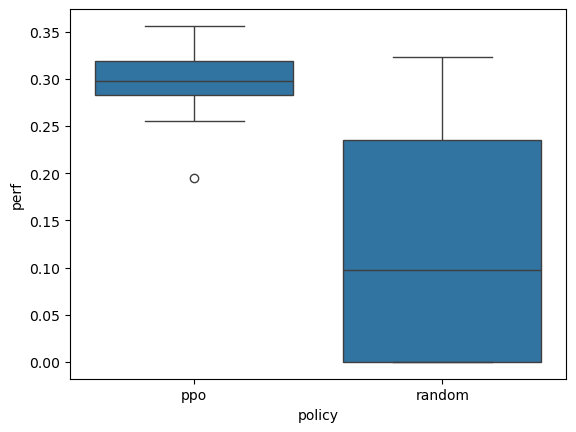

In [7]:
res = pd.DataFrame({'policy':['ppo']*n + ['random']*n, 'perf':policy_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()

In [5]:
rand_perf

[0.14082449674606323,
 0.1533355712890625,
 0,
 0,
 0.05491459369659424,
 0,
 0,
 0.32265985012054443,
 0.2618330717086792,
 0.3116953372955322]

In [6]:
baseline_perf

[]

In [17]:
res

,action,perf
0,policy,0.387719
1,policy,0.392071
2,policy,0.167701
3,policy,0.412015
4,policy,0.410178
5,baseline,0.395513
6,baseline,0.377342
7,baseline,0.172750
8,baseline,0.403196
9,baseline,0.375111


In [225]:
rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

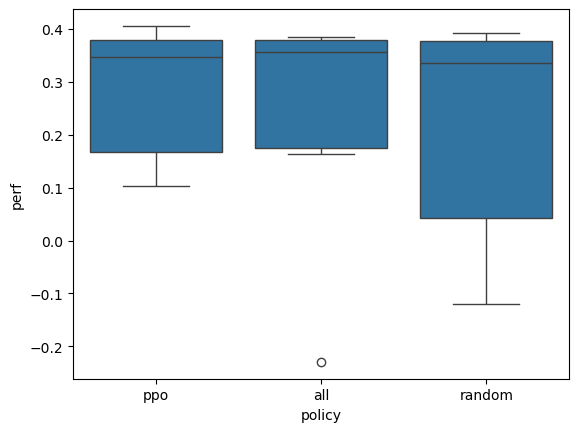

In [228]:
res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


progress: 1/10


progress: 2/10: 6/25 | train loss: 8.8 || val perf: 0.30651
progress: 3/10: 9/25 | train loss: 4.3 || val perf: 0.088973
progress: 4/10: 16/25 | train loss: 6.6 || val perf: -0.033
progress: 5/10: 9/25 | train loss: 12.3 || val perf: 0.373
progress: 6/10: 8/25 | train loss: 5.8 || val perf: 0.354956
progress: 7/10: 12/25 | train loss: 8.4 || val perf: 0.3436
progress: 8/10: 12/25 | train loss: 10.7 || val perf: 0.318
progress: 9/10: 14/25 | train loss: 13.4 || val perf: 0.3228
progress: 10/10 8/25 | train loss: 818.5 || val perf: 0.1075166


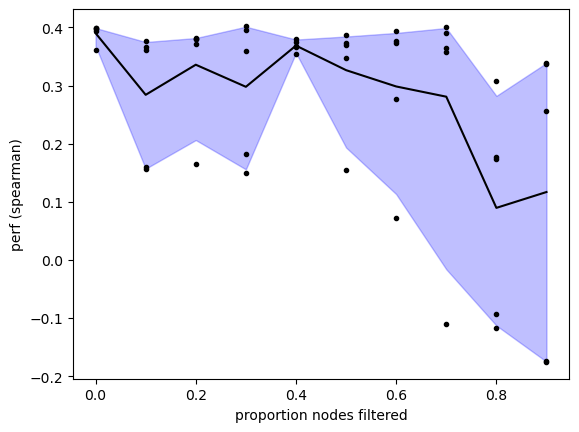

In [223]:
# this should really be done with a test dataset ... 

env.train_dataset.root = '../../processed_data/'
env.val_dataset.root = '../../processed_data/'

qs=np.linspace(0., 0.9, 10)
perfs = []

for i,q in enumerate(qs): 
    print(f'progress: {i+1}/{len(qs)}')
    repls = []
    for j in range(5): 
        t = np.quantile(p, q=[q])[0]
        action = torch.tensor((1.*(p>t)), dtype=torch.float32)
        repls.append( env.run(action) )
    perfs.append(repls)

p_mean = [np.mean(p) for p in perfs]
p_q05 = [np.quantile(p, q=[0.05])[0] for p in perfs]
p_q95 = [np.quantile(p, q=[0.95])[0] for p in perfs]

plt.figure()
plt.plot(qs, p_mean, 'k-')
plt.fill_between(qs, p_q05, p_q95, color='b', alpha=0.25)

for i in range(5): 
    plt.plot(qs, [p[i] for p in perfs], 'k.')

plt.ylabel('perf (spearman)')
plt.xlabel('proportion nodes filtered')
plt.show()